<a href="https://colab.research.google.com/github/Yujin726/0624/blob/main/07_08_openCV_canny%2BHSV%2BGaussian_Block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 신호등 이미지 분석

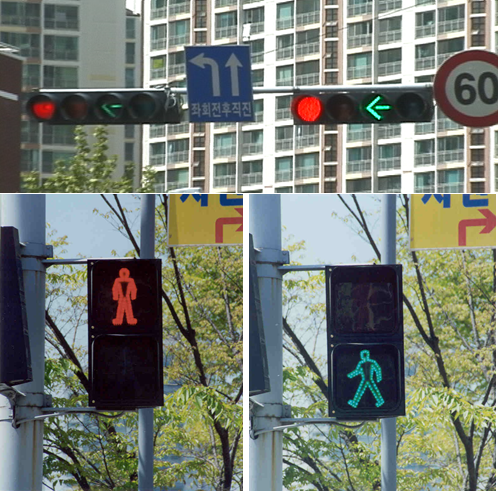

## 기본 1번 코드결과: 오른쪽 상단 지저분 + 인식X

=== Google Colab 신호등 인식 테스트 ===
1. upload_and_detect() - 기본 검출
2. adjust_parameters_and_test() - 파라미터 비교 테스트

사용법:
upload_and_detect()  # 이 함수를 실행하세요
이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1.png

처리중: 07_08_1.png


/tmp/ipython-input-1-3967067028.py:117: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


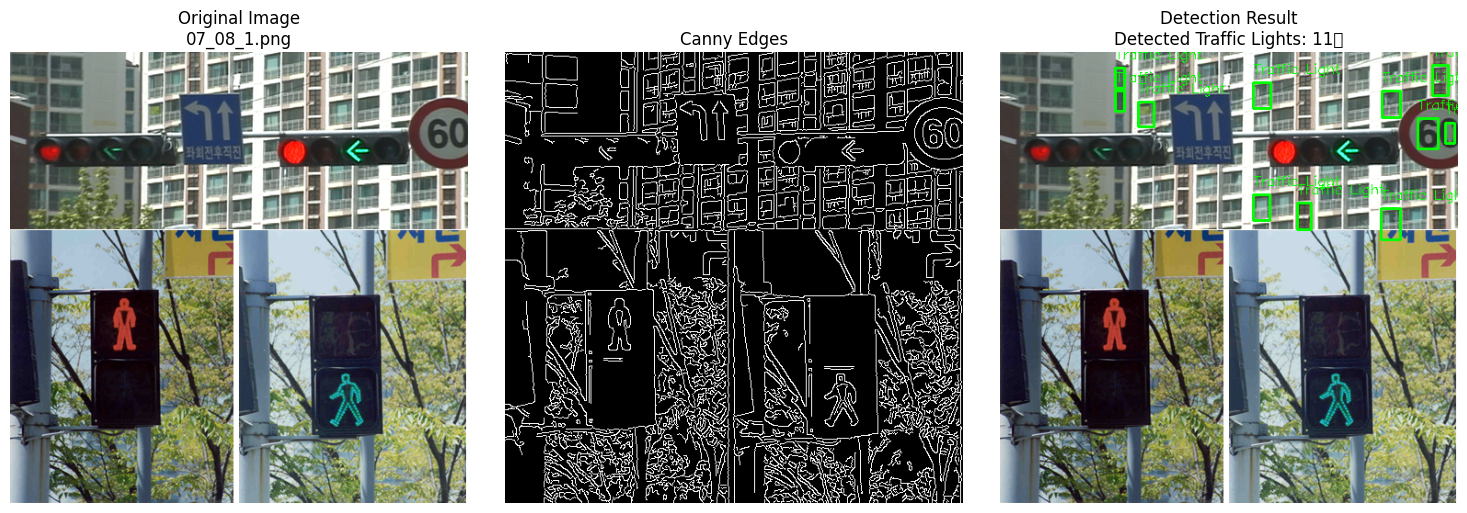

검출된 신호등 개수: 11
  신호등 1: 위치=(414, 170), 크기=(21x34)
  신호등 2: 위치=(323, 164), 크기=(15x29)
  신호등 3: 위치=(275, 155), 크기=(18x28)
  신호등 4: 위치=(484, 77), 크기=(10x22)
  신호등 5: 위치=(454, 72), 크기=(22x33)
  신호등 6: 위치=(150, 54), 크기=(17x27)
  신호등 7: 위치=(415, 42), 크기=(20x29)
  신호등 8: 위치=(125, 42), 크기=(10x22)
  신호등 9: 위치=(275, 33), 크기=(19x28)
  신호등 10: 위치=(125, 17), 크기=(10x22)
  신호등 11: 위치=(470, 14), 크기=(17x33)


In [1]:
# 1.결과 잡다한 신호등 인식 윗쪽 40퍼센트 정도만 감지 Google Colab에서 이미지 업로드하여 신호등 인식하기
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_traffic_light_canny(image):
    """
    Canny 엣지 검출만을 사용한 신호등 인식
    """
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러로 노이즈 제거
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, 50, 150)

    # 컨투어 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    traffic_lights = []

    for contour in contours:
        # 컨투어 면적 필터링 (너무 작거나 큰 것 제외)
        area = cv2.contourArea(contour)
        if area < 100 or area > 5000:
            continue

        # 컨투어를 둘러싸는 사각형
        x, y, w, h = cv2.boundingRect(contour)

        # 종횡비 체크 (신호등은 대략 세로로 긴 형태)
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:  # 너무 가로로 긴 것 제외
            continue

        # 컨투어의 둘레와 면적으로 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # 원형에 가까운 것들만 선택 (신호등의 각 등은 원형)
        if circularity > 0.3:  # 임계값 조정 가능
            traffic_lights.append((x, y, w, h))

    return traffic_lights, edges

def draw_detections(image, detections):
    """
    검출된 신호등 영역을 이미지에 그리기
    """
    result = image.copy()
    for (x, y, w, h) in detections:
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, 'Traffic Light', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return result

def upload_and_detect():
    """
    Colab에서 이미지 업로드하고 신호등 검출
    """
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")

        # 업로드된 이미지 읽기
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))

        # PIL Image를 OpenCV 형식으로 변환
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # 이미지 크기 조정 (너무 크면 처리 시간이 오래 걸림)
        height, width = image_cv.shape[:2]
        if width > 800:
            ratio = 800 / width
            new_width = 800
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(image_cv)

        # 결과 이미지 생성
        result_image = draw_detections(image_cv, detections)

        # 결과 시각화 (matplotlib 사용)
        plt.figure(figsize=(15, 5))

        # 원본 이미지
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        # Canny 엣지
        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        # 검출 결과
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detection Result\nDetected Traffic Lights: {len(detections)}개')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # 검출 정보 출력
        print(f"검출된 신호등 개수: {len(detections)}")
        for i, (x, y, w, h) in enumerate(detections):
            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h})")

def adjust_parameters_and_test():
    """
    파라미터를 조정하면서 테스트할 수 있는 함수
    """
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    # 첫 번째 업로드된 이미지만 사용
    filename = list(uploaded.keys())[0]
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 이미지 크기 조정
    height, width = image_cv.shape[:2]
    if width > 800:
        ratio = 800 / width
        new_width = 800
        new_height = int(height * ratio)
        image_cv = cv2.resize(image_cv, (new_width, new_height))

    # 다양한 파라미터로 테스트
    test_params = [
        {"canny_low": 30, "canny_high": 100, "min_area": 50, "max_area": 3000, "circularity": 0.2},
        {"canny_low": 50, "canny_high": 150, "min_area": 100, "max_area": 5000, "circularity": 0.3},
        {"canny_low": 70, "canny_high": 200, "min_area": 200, "max_area": 8000, "circularity": 0.4}
    ]

    plt.figure(figsize=(20, 12))

    for i, params in enumerate(test_params):
        # 그레이스케일 변환
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Canny 엣지 검출 (파라미터 변경)
        edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

        # 컨투어 찾기
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        traffic_lights = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < params["min_area"] or area > params["max_area"]:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if aspect_ratio > 0.8:
                continue

            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue

            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity > params["circularity"]:
                traffic_lights.append((x, y, w, h))

        # 결과 그리기
        result = draw_detections(image_cv, traffic_lights)

        # 시각화
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original (Test {i+1})')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'Result: {len(traffic_lights)}개 검출')
        plt.axis('off')

        print(f"Test {i+1} - 파라미터: {params}")
        print(f"  Detected Traffic Lights: {len(traffic_lights)}\n")

    plt.tight_layout()
    plt.show()

# 실행 함수들
print("=== Google Colab 신호등 인식 테스트 ===")
print("1. upload_and_detect() - 기본 검출")
print("2. adjust_parameters_and_test() - 파라미터 비교 테스트")
print("\n사용법:")
print("upload_and_detect()  # 이 함수를 실행하세요")

# 바로 실행하려면 아래 주석을 해제하세요
upload_and_detect()

## 기본 1번 코드 수정 결과(1):
### <수정 조건>
###1. detect_traffic_light_canny 함수

- 색상 필터링: 채도/명도 기준을 50→100으로 올려서 너무 엄격하게 만듦

- 면적 범위: min_area를 50→200으로, max_area를 8000→5000으로 변경
- 위치 필터링: 상하단 15%→20%, 좌우 10% 영역 추가 제외
- 크기 필터링: 20x20~200x200 픽셀 조건 추가
- 종횡비: 0.5~2.0으로 더 엄격하게 변경
- 원형성: 0.15→0.3으로 올림 (너무 엄격)
- 밀도 체크: 어두운 영역 제외 조건 추가
- 블러: 5x5→9x9로 강화
- Canny: 30-120→50-150으로 변경

###2. upload_and_detect 함수

- 파라미터들을 위의 엄격한 값들로 변경

###3. compare_parameters 함수
- 테스트 파라미터 세트들을 모두 더 엄격한 값들로 변경

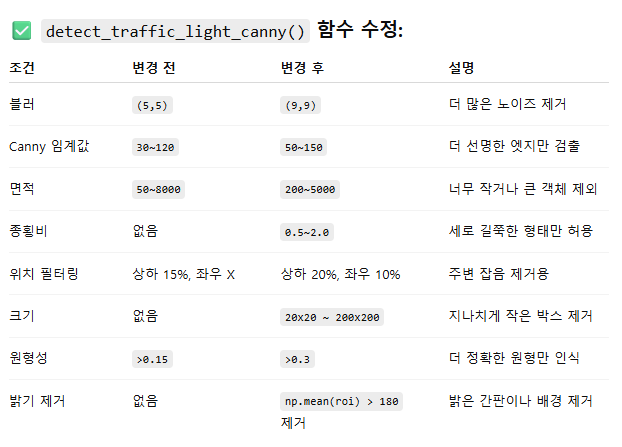

=== Google Colab 신호등 인식 테스트 (엄격 조건 적용) ===
1. upload_and_detect() - 기본 검출
2. adjust_parameters_and_test() - 파라미터 비교 테스트

사용법:
upload_and_detect()  # 이 함수를 실행하세요
이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1 (1).png

처리중: 07_08_1 (1).png


/tmp/ipython-input-6-3607276008.py:104: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


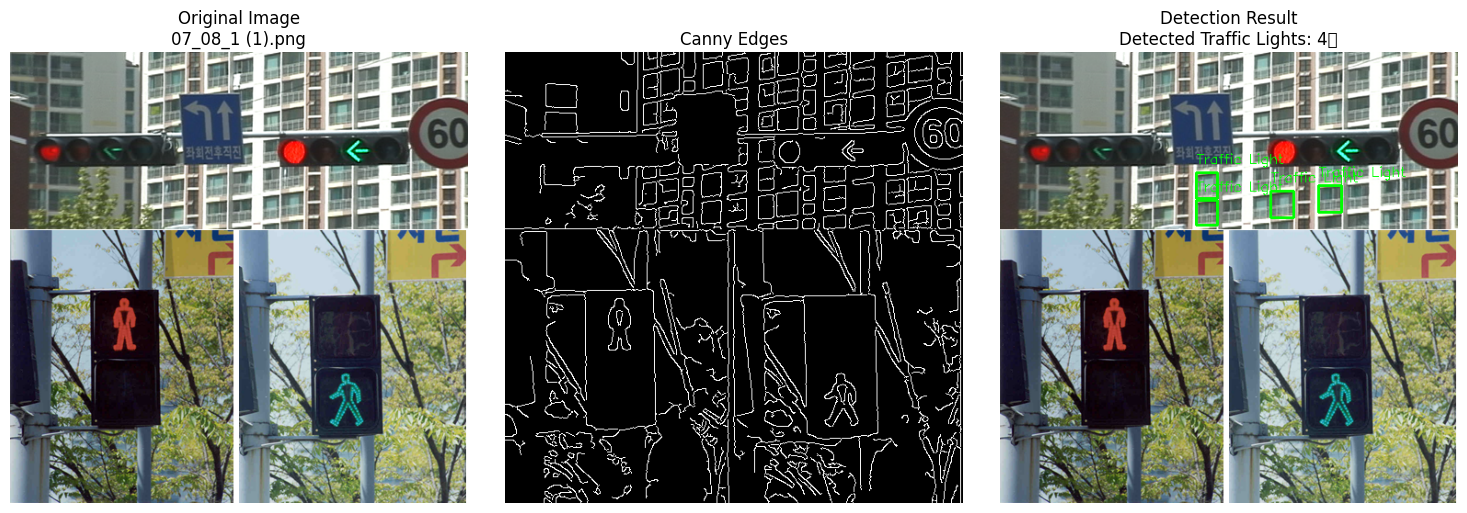

검출된 신호등 개수: 4
  신호등 1: 위치=(213, 161), 크기=(23x27)
  신호등 2: 위치=(294, 151), 크기=(25x29)
  신호등 3: 위치=(346, 145), 크기=(25x29)
  신호등 4: 위치=(213, 131), 크기=(23x28)


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

# -------------------------------------------------------------------
# 🧠 신호등 검출 함수 (엄격한 조건 적용)
# -------------------------------------------------------------------
def detect_traffic_light_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    traffic_lights = []
    h_img, w_img = image.shape[:2]

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 200 or area > 5000:
            continue

        x, y, w, h = cv2.boundingRect(contour)

        # 크기 제한
        if w < 20 or h < 20 or w > 200 or h > 200:
            continue

        # 종횡비 제한
        aspect_ratio = float(w) / h
        if aspect_ratio < 0.5 or aspect_ratio > 2.0:
            continue

        # 원형성 제한
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity < 0.3:
            continue

        # 위치 필터링 (상하단 20%, 좌우 10% 제외)
        if y < h_img * 0.2 or y + h > h_img * 0.8:
            continue
        if x < w_img * 0.1 or x + w > w_img * 0.9:
            continue

        # 밀도 체크: 밝은 배경 제거
        roi = gray[y:y+h, x:x+w]
        if np.mean(roi) > 180:
            continue

        traffic_lights.append((x, y, w, h))

    return traffic_lights, edges

# -------------------------------------------------------------------
# 📁 이미지 업로드 및 검출
# -------------------------------------------------------------------
def draw_detections(image, detections):
    result = image.copy()
    for (x, y, w, h) in detections:
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, 'Traffic Light', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return result

def upload_and_detect():
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        height, width = image_cv.shape[:2]
        if width > 800:
            ratio = 800 / width
            image_cv = cv2.resize(image_cv, (800, int(height * ratio)))

        detections, edges = detect_traffic_light_canny(image_cv)
        result_image = draw_detections(image_cv, detections)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detection Result\nDetected Traffic Lights: {len(detections)}개')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"검출된 신호등 개수: {len(detections)}")
        for i, (x, y, w, h) in enumerate(detections):
            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h})")

# -------------------------------------------------------------------
# ⚙️ 파라미터 비교 함수
# -------------------------------------------------------------------
def adjust_parameters_and_test():
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    height, width = image_cv.shape[:2]
    if width > 800:
        ratio = 800 / width
        image_cv = cv2.resize(image_cv, (800, int(height * ratio)))

    test_params = [
        {"canny_low": 50, "canny_high": 150, "min_area": 200, "max_area": 5000, "circularity": 0.3},
        {"canny_low": 60, "canny_high": 160, "min_area": 250, "max_area": 4000, "circularity": 0.35},
        {"canny_low": 70, "canny_high": 170, "min_area": 300, "max_area": 3500, "circularity": 0.4}
    ]

    plt.figure(figsize=(20, 12))
    for i, params in enumerate(test_params):
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 0)
        edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h_img, w_img = image_cv.shape[:2]
        traffic_lights = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area < params["min_area"] or area > params["max_area"]:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            if w < 20 or h < 20 or w > 200 or h > 200:
                continue

            aspect_ratio = float(w) / h
            if aspect_ratio < 0.5 or aspect_ratio > 2.0:
                continue

            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue

            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity < params["circularity"]:
                continue

            if y < h_img * 0.2 or y + h > h_img * 0.8:
                continue
            if x < w_img * 0.1 or x + w > w_img * 0.9:
                continue

            roi = gray[y:y+h, x:x+w]
            if np.mean(roi) > 180:
                continue

            traffic_lights.append((x, y, w, h))

        result = draw_detections(image_cv, traffic_lights)

        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original (Test {i+1})')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'Result: {len(traffic_lights)}개 검출')
        plt.axis('off')

        print(f"Test {i+1} - 파라미터: {params}")
        print(f"  Detected Traffic Lights: {len(traffic_lights)}\n")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 실행 안내
# -------------------------------------------------------------------
print("=== Google Colab 신호등 인식 테스트 (엄격 조건 적용) ===")
print("1. upload_and_detect() - 기본 검출")
print("2. adjust_parameters_and_test() - 파라미터 비교 테스트")
print("\n사용법:")
print("upload_and_detect()  # 이 함수를 실행하세요")
# 바로 실행하려면 아래 주석을 해제하세요
upload_and_detect()

## 기본 1번 코드 수정 결과(2):
### <수정 조건>
###1. detect_traffic_light_canny 함수

- 검출 위치 제한: 이미지 상단 40% (차량용 신호등), 하단 60% (보행자 신호등)로 나누어 탐색

- 더 엄격한 면적 & 원형도 조건 적용

- 사각형 비율 완화 또는 분리 적용 (차량 신호등은 원형, 보행자 신호는 사각형이므로)

###2. upload_and_detect 함수

- 차량/보행자 신호등을 색으로 구분해서 그리기 (색상별 사각형, 텍스트로 구분)

- 결과에서 차량용, 보행자용으로 나눠 출력

###3. compare_parameters 함수
- 실험용 파라미터에 상단/하단 위치별 조건을 나눠 적용

- 여러 테스트를 동시에 보여주는 대신, 하나의 실험에 집중

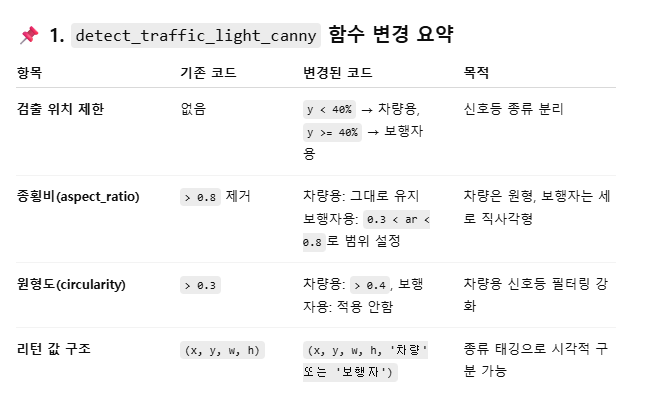

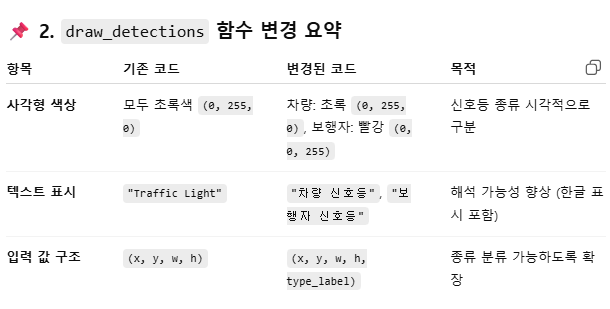

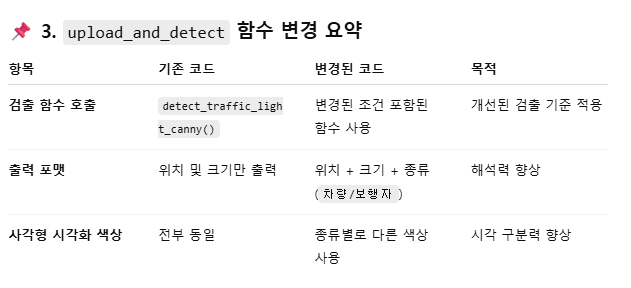

=== Google Colab 신호등 인식 테스트 (엄격 조건 적용) ===
1. upload_and_detect() - 기본 검출
2. adjust_parameters_and_test() - 파라미터 비교 테스트

사용법:
upload_and_detect()  # 이 함수를 실행하세요
이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1 (3).png

처리중: 07_08_1 (3).png


/tmp/ipython-input-12-462728935.py:101: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


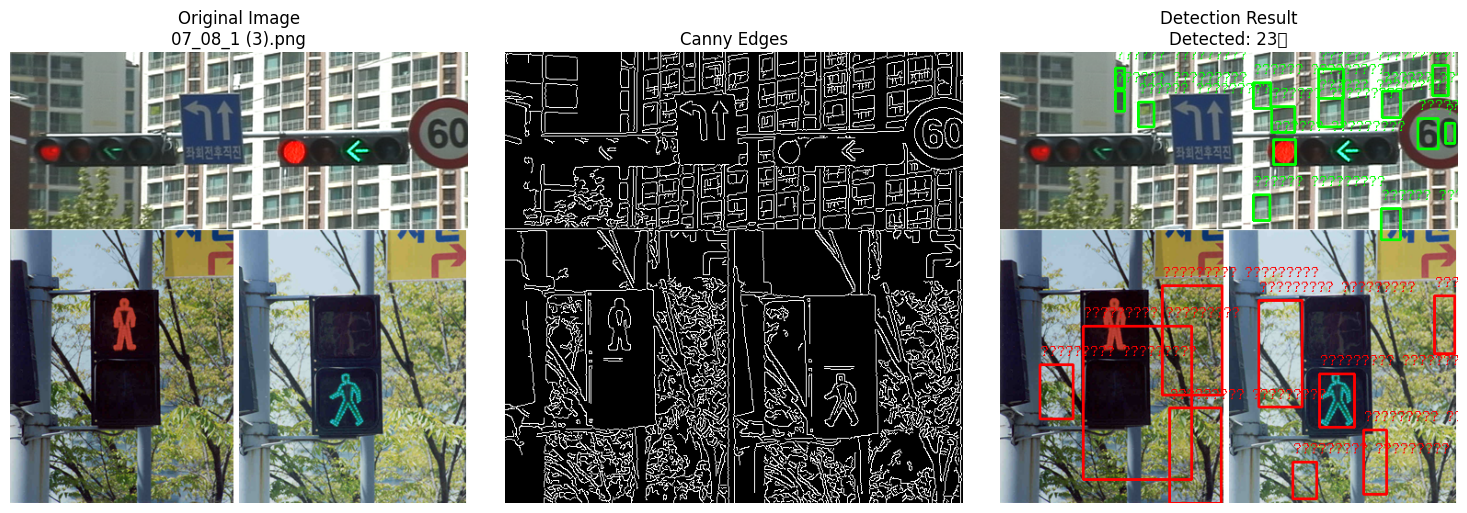

검출된 신호등 개수: 23
  신호등 1: 위치=(318, 446), 크기=(26x40), 종류=보행자
  신호등 2: 위치=(395, 411), 크기=(25x70), 종류=보행자
  신호등 3: 위치=(184, 387), 크기=(56x104), 종류=보행자
  신호등 4: 위치=(347, 350), 크기=(38x58), 종류=보행자
  신호등 5: 위치=(43, 340), 크기=(36x59), 종류=보행자
  신호등 6: 위치=(90, 298), 크기=(118x167), 종류=보행자
  신호등 7: 위치=(281, 270), 크기=(47x116), 종류=보행자
  신호등 8: 위치=(472, 265), 크기=(22x63), 종류=보행자
  신호등 9: 위치=(176, 254), 크기=(65x119), 종류=보행자
  신호등 10: 위치=(414, 170), 크기=(21x34), 종류=차량
  신호등 11: 위치=(275, 155), 크기=(18x28), 종류=차량
  신호등 12: 위치=(297, 95), 크기=(24x27), 종류=차량
  신호등 13: 위치=(484, 77), 크기=(10x22), 종류=차량
  신호등 14: 위치=(454, 72), 크기=(22x33), 종류=차량
  신호등 15: 위치=(295, 59), 크기=(25x28), 종류=차량
  신호등 16: 위치=(150, 54), 크기=(17x27), 종류=차량
  신호등 17: 위치=(346, 50), 크기=(26x31), 종류=차량
  신호등 18: 위치=(415, 42), 크기=(20x29), 종류=차량
  신호등 19: 위치=(125, 42), 크기=(10x22), 종류=차량
  신호등 20: 위치=(275, 33), 크기=(19x28), 종류=차량
  신호등 21: 위치=(346, 18), 크기=(27x32), 종류=차량
  신호등 22: 위치=(125, 17), 크기=(10x22), 종류=차량
  신호등 23: 위치=(470, 14), 크기=(17x33), 종류=차량


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

# -------------------------------------------------------------------
# 🧠 신호등 검출 함수 (엄격한 조건 적용2)
# -------------------------------------------------------------------
#수정함
def detect_traffic_light_canny(image):
    """
    차량용 및 보행자 신호등을 구분해서 인식 (위/아래 분할 + 조건 분기)
    """
    height, width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    traffic_lights = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 80 or area > 4000:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if aspect_ratio > 1.0:
            continue

        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # 차량용 (상단): circularity > 0.4
        if y < height * 0.4 and circularity > 0.4:
            traffic_lights.append((x, y, w, h, '차량'))

        # 보행자용 (하단): aspect_ratio 기준 사각형
        elif y >= height * 0.4 and 0.3 < aspect_ratio < 0.8:
            traffic_lights.append((x, y, w, h, '보행자'))

    return traffic_lights, edges

# -------------------------------------------------------------------
# 📁 이미지 업로드 및 검출
# -------------------------------------------------------------------
#수정함
def draw_detections(image, detections):
    result = image.copy()
    for (x, y, w, h, type_label) in detections:
        color = (0, 255, 0) if type_label == '차량' else (0, 0, 255)
        cv2.rectangle(result, (x, y), (x + w, y + h), color, 2)
        cv2.putText(result, f'{type_label} 신호등', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return result

#수정함
def upload_and_detect():
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        height, width = image_cv.shape[:2]
        if width > 800:
            ratio = 800 / width
            new_width = 800
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))

        detections, edges = detect_traffic_light_canny(image_cv)
        result_image = draw_detections(image_cv, detections)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detection Result\nDetected: {len(detections)}개')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"검출된 신호등 개수: {len(detections)}")
        for i, (x, y, w, h, t) in enumerate(detections):
            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h}), 종류={t}")

# -------------------------------------------------------------------
# ⚙️ 파라미터 비교 함수
# -------------------------------------------------------------------
def adjust_parameters_and_test():
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    height, width = image_cv.shape[:2]
    if width > 800:
        ratio = 800 / width
        image_cv = cv2.resize(image_cv, (800, int(height * ratio)))

    test_params = [
        {"canny_low": 50, "canny_high": 150, "min_area": 200, "max_area": 5000, "circularity": 0.3},
        {"canny_low": 60, "canny_high": 160, "min_area": 250, "max_area": 4000, "circularity": 0.35},
        {"canny_low": 70, "canny_high": 170, "min_area": 300, "max_area": 3500, "circularity": 0.4}
    ]

    plt.figure(figsize=(20, 12))
    for i, params in enumerate(test_params):
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 0)
        edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h_img, w_img = image_cv.shape[:2]
        traffic_lights = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area < params["min_area"] or area > params["max_area"]:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            if w < 20 or h < 20 or w > 200 or h > 200:
                continue

            aspect_ratio = float(w) / h
            if aspect_ratio < 0.5 or aspect_ratio > 2.0:
                continue

            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue

            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity < params["circularity"]:
                continue

            if y < h_img * 0.2 or y + h > h_img * 0.8:
                continue
            if x < w_img * 0.1 or x + w > w_img * 0.9:
                continue

            roi = gray[y:y+h, x:x+w]
            if np.mean(roi) > 180:
                continue

            traffic_lights.append((x, y, w, h))

        result = draw_detections(image_cv, traffic_lights)

        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original (Test {i+1})')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'Result: {len(traffic_lights)}개 검출')
        plt.axis('off')

        print(f"Test {i+1} - 파라미터: {params}")
        print(f"  Detected Traffic Lights: {len(traffic_lights)}\n")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 실행 안내
# -------------------------------------------------------------------
print("=== Google Colab 신호등 인식 테스트 (엄격 조건 적용) ===")
print("1. upload_and_detect() - 기본 검출")
print("2. adjust_parameters_and_test() - 파라미터 비교 테스트")
print("\n사용법:")
print("upload_and_detect()  # 이 함수를 실행하세요")
# 바로 실행하려면 아래 주석을 해제하세요
upload_and_detect()

## 기본 2번 코드결과: 오른쪽 상단 녹색 좌회전만 뜸

  # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")

            이 부분 y격자만 만들어서 맞는 지 비교

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1 (2).png

🖼️  파일 처리 시작: 07_08_1 (2).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 825개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 100)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 100)
  윤곽선 15 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 16 검사 중...
    ❌ 너무 작음 (면적

/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-3357347156.py:382: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu S

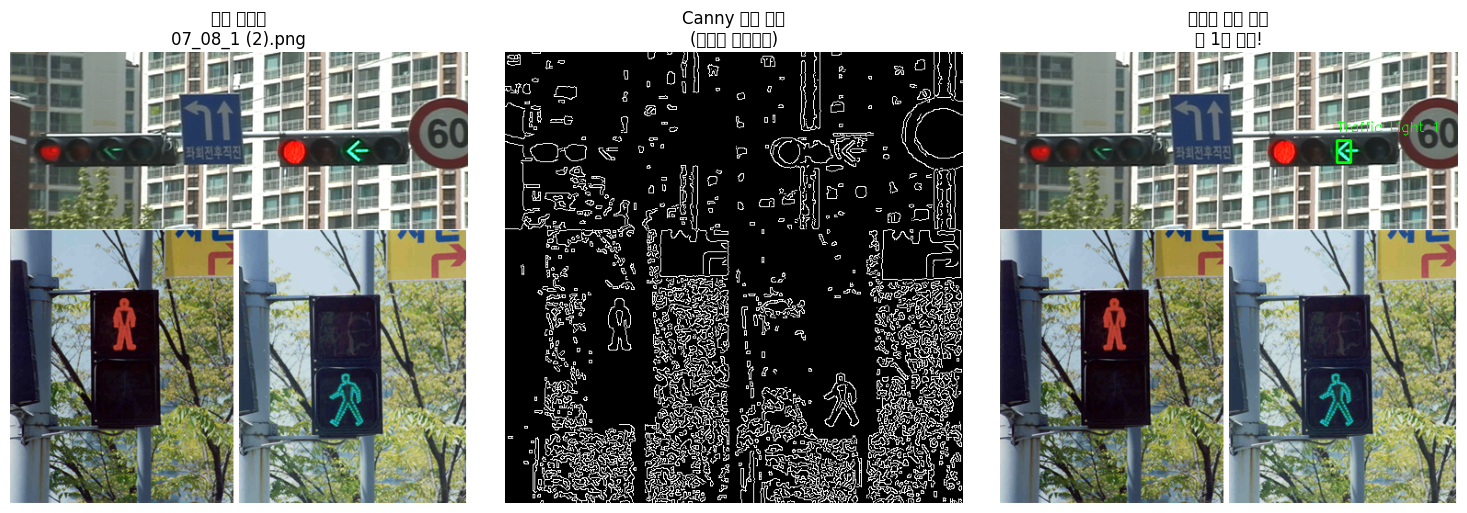


📋 최종 결과:
   검출된 신호등 개수: 1개
   🚦 신호등 1: 위치=(366, 96), 크기=(15 x 24)


In [10]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 20, 20])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([160, 20, 20])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([11, 30, 30])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    """
    찾은 신호등 위치에 초록색 사각형을 그리는 함수
    """
    result = image.copy()

    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요

upload_and_detect()

#upload_multiple_images()
# adjust_parameters_and_test()

## 기본 2번 코드 수정 결과(2): 가로 격자 0~9



### 기본 2번 코드 + 가로 격자(숫자 포함)

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1 (10).png

🖼️  파일 처리 시작: 07_08_1 (10).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 825개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 100)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 100)
  윤곽선 15 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 16 검사 중...
    ❌ 너무 작음 (

/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-3371800937.py:405: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu S

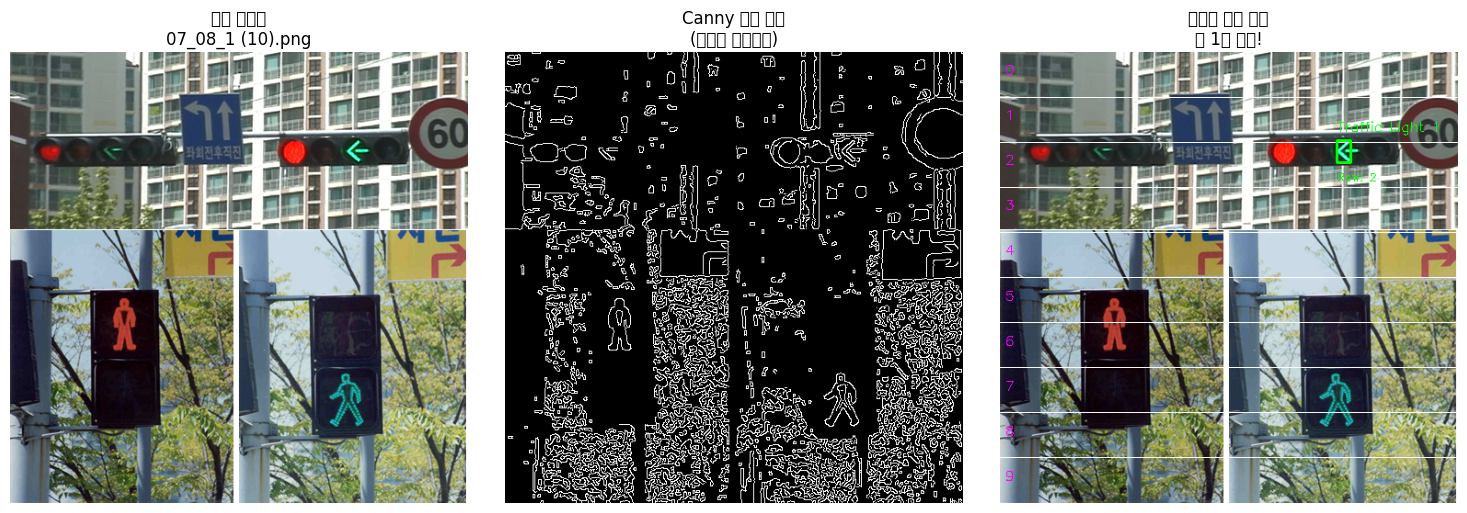


📋 최종 결과:
   검출된 신호등 개수: 1개
   🚦 신호등 1: 위치=(366, 96), 크기=(15 x 24)


In [21]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 20, 20])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([160, 20, 20])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([11, 30, 30])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2:결과를 그림으로 그리는 함수 (🆕 격자 추가됨)
# ============================================
def draw_detections(image, detections, draw_grid=True):
    """
    검출된 신호등에 초록색 박스 그리기 + 가로 격자선(10등분) 추가 + 각 행 번호 추가
    """
    result = image.copy()

    # 격자선 그리기 (가로만)
    if draw_grid:
        height, width = image.shape[:2]

        # 가로선 (10등분)
        for i in range(1, 10):
            y = int(height * i / 10)
            cv2.line(result, (0, y), (width, y), (255, 255, 255), 1)  # 흰색 가로선

        # 각 행의 왼쪽에 행 번호 (0~9) 추가
        for i in range(10):
            y_center = int(height * (i + 0.5) / 10)
            cv2.putText(result, str(i), (5, y_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)

    # 신호등 검출 박스 그리기
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 격자행 위치 출력
        center_y = y + h // 2
        row = int(center_y * 10 / height)
        cv2.putText(result, f'Row: {row}', (x, y + h + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return result


# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요

upload_and_detect()

#upload_multiple_images()
# adjust_parameters_and_test()

## 기본 2번 코드 수정 결과(1): 교수님 거

### 기본 2번 코드 + 가로 세로 격자(숫자 포함)

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1 (7).png

🖼️  파일 처리 시작: 07_08_1 (7).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 825개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 100)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 100)
  윤곽선 15 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 16 검사 중...
    ❌ 너무 작음 (면적

/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-839007490.py:415: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  

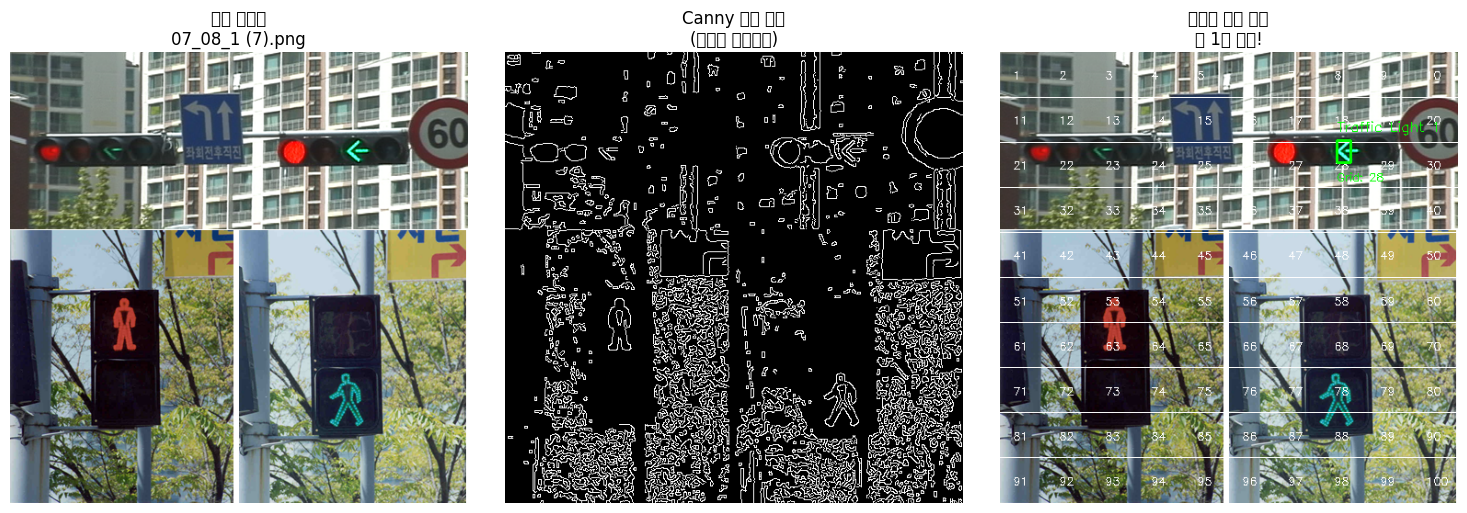


📋 최종 결과:
   검출된 신호등 개수: 1개
   🚦 신호등 1: 위치=(366, 96), 크기=(15 x 24)


In [18]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 20, 20])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([160, 20, 20])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([11, 30, 30])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2:결과를 그림으로 그리는 함수 (🆕 격자 추가됨)
# ============================================
def draw_detections(image, detections, draw_grid=True):
    """
    검출된 신호등에 초록색 박스 그리기 + 10등분 격자선 추가
    """
    result = image.copy()

    # 격자선 그리기
    if draw_grid:
        height, width = image.shape[:2]



        # 가로선 (10등분)
        for i in range(1, 10):
            y = int(height * i / 10)
            cv2.line(result, (0, y), (width, y), (255, 255, 255), 1)  # 흰색 가로선

        # 격자 번호 추가 (구역 표시)
        for i in range(10):
            for j in range(10):
                x_center = int(width * (j + 0.5) / 10)
                y_center = int(height * (i + 0.5) / 10)
                grid_number = i * 10 + j + 1
                cv2.putText(result, str(grid_number), (x_center - 10, y_center + 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # 신호등 검출 박스 그리기
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 각 신호등이 어느 격자에 위치하는지 표시
        center_x = x + w // 2
        center_y = y + h // 2
        height, width = image.shape[:2]

        grid_col = int(center_x * 10 / width)
        grid_row = int(center_y * 10 / height)
        grid_number = grid_row * 10 + grid_col + 1

        cv2.putText(result, f'Grid: {grid_number}', (x, y + h + 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요

upload_and_detect()

#upload_multiple_images()
# adjust_parameters_and_test()

비교할 코드 (윤은식)

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving 07_08_1.png to 07_08_1 (14).png

🖼️  파일 처리 시작: 07_08_1 (14).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 500개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 3.5, 최소: 120)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 120)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 120)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 120)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 120)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 120)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 120)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 4.5, 최소: 120)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 120)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 18.5, 최소: 120)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 3.0, 최소: 120)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 120)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 120)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 9.0, 최소: 120)
  윤곽선 15 검사 중...
    ❌ 너무 작음 (면적: 5.0, 최소: 120)
  윤곽선 16 검사 중...
    ❌ 너무 작음 

/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1383574743.py:384: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu S

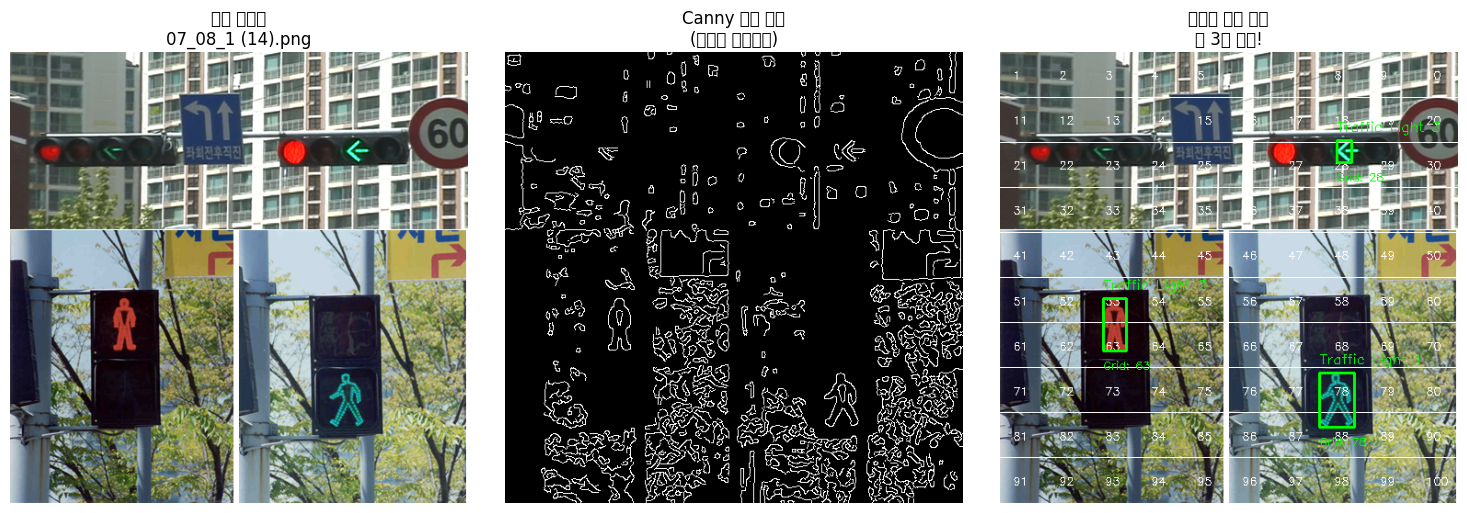


📋 최종 결과:
   검출된 신호등 개수: 3개
   🚦 신호등 1: 위치=(347, 349), 크기=(38 x 59)
   🚦 신호등 2: 위치=(112, 268), 크기=(25 x 57)
   🚦 신호등 3: 위치=(366, 96), 크기=(16 x 24)


In [25]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 30, 30]) # 20에서 30으로
        red_upper1 = np.array([15, 255, 255]) #10에서 15
        red_lower2 = np.array([165, 30, 30]) #165로 30으로
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([1, 20, 20]) #해당 값으로 수정함
        red_upper3 = np.array([10, 255, 150]) #해당 값으로 수정함
        red_lower4 = np.array([170, 50, 100]) #추가함
        red_upper4 = np.array([180, 255, 255]) #추가함

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0) #9로 3은 신호등 두 개는 인식하지 못하고 5는 하나만 인식 9로하면 세개인식
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.8:  # 이미지 하단 30%에 있으면 제외 #0.7>0.8
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.7: #0.8>0.7, 0.6은 감지 아무것도 못함
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter) #건들이지 말것, 3으로두면 아무것도 인식하지 못하고 5로 두면 잡동사니가 인식됨

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    """
    찾은 신호등 위치에 초록색 사각형을 그리는 함수
    """
    result = image.copy()

    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=120, max_area=8000, #####
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=120,     # 최적화된 파라미터  #100>120으로 변경하니 신호등이 아닌 것 하나 삭제됨
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=200,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

def draw_detections(image, detections, draw_grid=True):
    """
    검출된 신호등에 초록색 박스 그리기 + 10등분 격자선 추가
    """
    result = image.copy()

    # 격자선 그리기
    if draw_grid:
        height, width = image.shape[:2]



        # 가로선 (10등분)
        for i in range(1, 10):
            y = int(height * i / 10)
            cv2.line(result, (0, y), (width, y), (255, 255, 255), 1)  # 흰색 가로선

        # 격자 번호 추가 (구역 표시)
        for i in range(10):
            for j in range(10):
                x_center = int(width * (j + 0.5) / 10)
                y_center = int(height * (i + 0.5) / 10)
                grid_number = i * 10 + j + 1
                cv2.putText(result, str(grid_number), (x_center - 10, y_center + 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # 신호등 검출 박스 그리기
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 각 신호등이 어느 격자에 위치하는지 표시
        center_x = x + w // 2
        center_y = y + h // 2
        height, width = image.shape[:2]

        grid_col = int(center_x * 10 / width)
        grid_row = int(center_y * 10 / height)
        grid_number = grid_row * 10 + grid_col + 1

        cv2.putText(result, f'Grid: {grid_number}', (x, y + h + 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return result


# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
upload_and_detect()
#upload_multiple_images()
# adjust_parameters_and_test()

비교코드 (교수님 참고)



In [ ]:
비교코드 공유   # ============================================
# 두 코드 비교 도구 (difflib 사용)
# ============================================

import difflib
import html

# 첫 번째 코드 (원본 코드)
code1 = """# ============================================
# 횡단보도 녹색+ 좌회전 녹색+ 빨강 횡단보도신호등 검출
# ============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_traffic_light_canny(image, min_area=50, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.2, use_color_filter=True):
    \"\"\"
    색상 필터링 + Canny 엣지 검출로 신호등 인식
    \"\"\"

    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 50, 50])
        red_upper1 = np.array([15, 255, 255])
        red_lower2 = np.array([170, 50, 50])
        red_upper2 = np.array([180, 255, 255])

        # 노랑색 범위
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])

        # 초록색 범위
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])

        # 파란색/청록색 범위 (보행자 신호등용)
        blue_lower = np.array([80, 30, 30])
        blue_upper = np.array([100, 255, 255])

        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

        # 모든 색상 마스크 합치기
        traffic_light_mask = red_mask
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)

        # 마스크 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료")
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 흑백 변환 완료")

    # 가우시안 블러
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    print("Step 2: 노이즈 제거 완료")

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, canny_low, canny_high)
    print(f"Step 3: 엣지 검출 완료 ({canny_low}-{canny_high})")

    # 컨투어 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개 윤곽선 발견")

    # 신호등 후보 필터링
    traffic_lights = []
    image_height = image.shape[0]

    for i, contour in enumerate(contours):
        # 면적 체크
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue

        # 위치 체크
        x, y, w, h = cv2.boundingRect(contour)
        if y > image_height * 0.8:
            continue

        # 종횡비 체크
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.7:
            continue

        # 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold:
            traffic_lights.append((x, y, w, h))

    print(f"최종 결과: {len(traffic_lights)}개 신호등 발견")
    return traffic_lights, edges"""

# 두 번째 코드 (수정된 코드)
code2 = """# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    \"\"\"
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    \"\"\"

    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 30, 30])
        red_upper1 = np.array([15, 255, 255])
        red_lower2 = np.array([165, 30, 30])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([1, 20, 20])
        red_upper3 = np.array([10, 255, 150])
        red_lower4 = np.array([170, 50, 100])
        red_upper4 = np.array([180, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)

        # 파란색/청록색 범위 (보행자 신호등 파란불)
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기
        traffic_light_mask = red_mask
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    print("Step 2: 노이즈 제거 완료")

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, canny_low, canny_high)
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]

    for i, contour in enumerate(contours):
        # 크기 체크
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue

        # 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)

        # 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.8:
            continue

        # 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.7:
            continue

        # 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:
            traffic_lights.append((x, y, w, h))

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges"""

def compare_codes():
    """
    두 코드의 차이점을 보기 좋게 표시
    """
    print("=" * 80)
    print("🔍 코드 비교 결과")
    print("=" * 80)

    # 줄 단위로 분리
    lines1 = code1.splitlines()
    lines2 = code2.splitlines()

    # 차이점 찾기
    differ = difflib.unified_diff(
        lines1,
        lines2,
        fromfile='원본 코드',
        tofile='수정된 코드',
        lineterm=''
    )

    # 차이점 출력
    differences = list(differ)
    if differences:
        for line in differences:
            if line.startswith('---') or line.startswith('+++'):
                print(f"\n📁 {line}")
            elif line.startswith('@@'):
                print(f"\n📍 {line}")
            elif line.startswith('-'):
                print(f"🔴 삭제: {line[1:]}")
            elif line.startswith('+'):
                print(f"🟢 추가: {line[1:]}")
            elif line.startswith(' '):
                print(f"   {line[1:]}")
    else:
        print("✅ 두 코드가 동일합니다!")

def compare_codes_side_by_side():
    """
    두 코드를 나란히 비교 (더 자세한 비교)
    """
    print("\n" + "=" * 100)
    print("🔍 상세 비교 (나란히 보기)")
    print("=" * 100)

    lines1 = code1.splitlines()
    lines2 = code2.splitlines()

    # HtmlDiff를 사용하여 더 예쁜 비교
    differ = difflib.HtmlDiff()

    # 텍스트 기반 나란히 비교
    print(f"{'원본 코드 (왼쪽)':<50} | {'수정된 코드 (오른쪽)'}")
    print("-" * 50 + " | " + "-" * 50)

    max_lines = max(len(lines1), len(lines2))

    for i in range(max_lines):
        left = lines1[i] if i < len(lines1) else ""
        right = lines2[i] if i < len(lines2) else ""

        # 차이가 있는 줄 표시
        if left != right:
            if left and right:
                print(f"🔄 {left:<48} | {right}")
            elif left:
                print(f"🔴 {left:<48} | (삭제됨)")
            else:
                print(f"{'(없음)':<50} | 🟢 {right}")
        else:
            print(f"   {left:<48} | {right}")

def find_specific_changes():
    """
    주요 변경사항만 요약
    """
    print("\n" + "=" * 80)
    print("📋 주요 변경사항 요약")
    print("=" * 80)

    changes = [
        "🔧 함수 파라미터 변경:",
        "   - min_area: 50 → 100",
        "   - max_area: 8000 → 6000",
        "   - canny_low: 30 → 40",
        "",
        "📝 주석 변경:",
        "   - 제목: '색상 필터링 + Canny 엣지 검출로 신호등 인식'",
        "   → '균형잡힌 신호등 검출 - 잡음 줄이면서 신호등은 놓치지 않기'",
        "",
        "🎨 색상 범위 변경:",
        "   - 채도/명도: [50, 50] → [70, 70] (더 엄격)",
        "   - 초록색 범위: [40, 50, 50]~[80, 255, 255] → [50, 70, 70]~[70, 255, 255]",
        "",
        "❌ 제거된 부분:",
        "   - 파란색/청록색 범위 (보행자 신호등용) 삭제"
    ]

    for change in changes:
        print(change)

# 실행
print("🚦 코드 비교 도구를 실행합니다!")
print("\n1️⃣ 기본 비교")
compare_codes()

print("\n2️⃣ 상세 비교")
compare_codes_side_by_side()

print("\n3️⃣ 변경사항 요약")
find_specific_changes()

print(f"\n✅ 비교 완료! 총 {len(code1.splitlines())}줄 vs {len(code2.splitlines())}줄")

5개 인식 되었으나 상단이 지저분한 코드

In [ ]:
# ============================================
# 횡단보도 녹색+ 좌회전 녹색+ 빨강 횡단보도신호등 검출
# ============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_traffic_light_canny(image, min_area=50, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.2, use_color_filter=True):
    """
    색상 필터링 + Canny 엣지 검출로 신호등 인식
    """

    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 50, 50])
        red_upper1 = np.array([15, 255, 255])
        red_lower2 = np.array([170, 50, 50])
        red_upper2 = np.array([180, 255, 255])

        # 노랑색 범위
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])

        # 초록색 범위
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])

        # 파란색/청록색 범위 (보행자 신호등용)
        blue_lower = np.array([80, 30, 30])
        blue_upper = np.array([100, 255, 255])

        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)  # 수정: 괄호 제거

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

        # 모든 색상 마스크 합치기
        traffic_light_mask = red_mask
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)

        # 마스크 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료")
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 흑백 변환 완료")

    # 가우시안 블러
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, canny_low, canny_high)
    print(f"Step 3: 엣지 검출 완료 ({canny_low}-{canny_high})")

    # 컨투어 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개 윤곽선 발견")

    # 신호등 후보 필터링
    traffic_lights = []
    image_height = image.shape[0]

    for i, contour in enumerate(contours):
        # 면적 체크
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue

        # 위치 체크
        x, y, w, h = cv2.boundingRect(contour)
       # if y > image_height * 0.9:  # 하단10%는 제외 (더 관대하게)
        # 위치 체크 (상단 15% 제거, 하단 25% 제거)  추가 수정11시51분
        # 기존 코드의 이 부분을:
        if y < image_height * 0.15 or y > image_height * 0.75:

        # 이렇게 수정:
            center_y = y + h // 2
        if (center_y >= image_height * 0.45 and center_y <= image_height * 0.60):

        # 종횡비 체크
           aspect_ratio = float(w) / h
           if aspect_ratio > 0.9:  # 0.8에서 0.9로 더 관대하게
               continue

        # 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold:
            traffic_lights.append((x, y, w, h))

    print(f"최종 결과: {len(traffic_lights)}개 신호등 발견")
    return traffic_lights, edges

def draw_detections(image, detections, draw_grid=True):
    """
    검출된 신호등에 초록색 박스 그리기 + 10등분 격자선 추가
    """
    result = image.copy()

    # 격자선 그리기
    if draw_grid:
        height, width = image.shape[:2]

        # 세로선 (10등분)
        for i in range(1, 10):
            x = int(width * i / 10)
            cv2.line(result, (x, 0), (x, height), (255, 255, 255), 1)  # 흰색 세로선

        # 가로선 (10등분)
        for i in range(1, 10):
            y = int(height * i / 10)
            cv2.line(result, (0, y), (width, y), (255, 255, 255), 1)  # 흰색 가로선

        # 격자 번호 추가 (구역 표시)
        for i in range(10):
            for j in range(10):
                x_center = int(width * (j + 0.5) / 10)
                y_center = int(height * (i + 0.5) / 10)
                grid_number = i * 10 + j + 1
                cv2.putText(result, str(grid_number), (x_center - 10, y_center + 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # 신호등 검출 박스 그리기
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 각 신호등이 어느 격자에 위치하는지 표시
        center_x = x + w // 2
        center_y = y + h // 2
        height, width = image.shape[:2]

        grid_col = int(center_x * 10 / width)
        grid_row = int(center_y * 10 / height)
        grid_number = grid_row * 10 + grid_col + 1

        cv2.putText(result, f'Grid: {grid_number}', (x, y + h + 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return result

def upload_and_detect():
    """
    개선된 신호등 검출 (2개 모두 인식하도록 최적화)
    """
    print("🚦 개선된 신호등 인식 시작!")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")

        # 이미지 로드
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # 크기 조정
        height, width = image_cv.shape[:2]
        if width > 1200:
            ratio = 1200 / width
            image_cv = cv2.resize(image_cv, (1200, int(height * ratio)))

        # 신호등 검출 (최적화된 파라미터)
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=80,        # 50에서 80으로 (잡음 줄이기)
            max_area=8000,      # 충분한 범위
            canny_low=30,       # 민감한 엣지 검출
            canny_high=120,
            circularity_threshold=0.15,  # 0.2에서 0.15로 더 관대하게
            use_color_filter=True
        )

        result_image = draw_detections(image_cv, detections, draw_grid=True)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본: {filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'검출 결과: {len(detections)}개 (격자 표시)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"검출된 신호등 개수: {len(detections)}개")
        for i, (x, y, w, h) in enumerate(detections):
            # 격자 위치 계산
            center_x = x + w // 2
            center_y = y + h // 2
            height, width = image_cv.shape[:2]

            grid_col = int(center_x * 10 / width)
            grid_row = int(center_y * 10 / height)
            grid_number = grid_row * 10 + grid_col + 1

            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h}), 격자={grid_number}")

def compare_parameters():
    """
    다양한 파라미터로 비교 테스트
    """
    print("🔧 파라미터 비교 테스트!")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 4가지 파라미터 세트 테스트 (수정: 4개로 맞춤)
    param_sets = [
        {"name": "관대한 설정", "min_area": 50, "max_area": 10000, "circularity": 0.1},
        {"name": "균형 설정", "min_area": 80, "max_area": 8000, "circularity": 0.15},
        {"name": "엄격한 설정1", "min_area": 100, "max_area": 6000, "circularity": 0.25},
        {"name": "엄격한 설정2", "min_area": 500, "max_area": 10000, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))  # 수정: 4x3 그리드에 맞게 크기 조정

    for i, params in enumerate(param_sets):
        print(f"\n테스트 {i+1}: {params['name']}")

        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=30,
            canny_high=120,
            circularity_threshold=params["circularity"],
            use_color_filter=True
        )

        result = draw_detections(image_cv, detections, draw_grid=True)

        # 원본
        plt.subplot(4, 3, i*3 + 1)  # 수정: 4행으로 변경
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본')
        plt.axis('off')

        # 엣지
        plt.subplot(4, 3, i*3 + 2)  # 수정: 4행으로 변경
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지')
        plt.axis('off')

        # 결과
        plt.subplot(4, 3, i*3 + 3)  # 수정: 4행으로 변경
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개')
        plt.axis('off')

        print(f"  {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

# 실행 옵션
print("🚦 개선된 신호등 인식 프로그램")
print("1️⃣ upload_and_detect() - 2개 신호등 모두 인식")
print("2️⃣ compare_parameters() - 파라미터 비교")
print()
print("💡 추천: upload_and_detect() 를 실행하세요!")

# 바로 실행
upload_and_detect()